# Tutorial: recomposing Pärt's _Summa_ in Python

_Bas Cornelissen_

_Last updated on 1 February 2022_

**In this tutorial we go through our reconstruction of _Summa_ in a bit more detail. Additional code examples and figures illustrate how the different steps work, and hopefully also show how to attempt recomposing other works by Pärt algorithmically. We rely on our own implementation of some tintinnabuli concepts: `tintinnabulipy`. This allows us to give a fairly concise implementation of _Summa_, as is clearer from the 'Algo Pärt' notebook, which is essentially a condensed version of this tutorial.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import music21
from copy import deepcopy

from music21.note import Note
from music21.pitch import Pitch
from music21.chord import Chord
from music21.scale import ConcreteScale
from music21.scale import MinorScale

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('styles.mplstyle')

import sys
sys.path.append('../')

from notebooks.utils import *
from tintinnabulipy import *

## 1. Basic Tintinnabulipy

First we cover some basic examples that illustrate how our music21 tintinnabuli framework works.

### The pitch spaces

A pitch space is basically a scale extended across octaves. So you take a set of pitches within one octave and then add all pitches that are octaves higher or lower than these. Every space also has a *pitch center*, which defaults to the tonic of the scale, but can also be another scale pitch.

In [3]:
M = MelodicSpace(MinorScale('E2'))
T = TintinnabuliSpace(Chord('E2 G2 B2'))

In [4]:
M

<MelodicSpace E minor center=E2>

One object we use internally a lot is the scale object used to construct the space:

In [5]:
M.scale, T.scale

(<music21.scale.MinorScale E minor>, <music21.scale.ConcreteScale E Concrete>)

You can easily test whether pitches lie in the space, and also how the spaces are related:

In [6]:
Pitch('C#2') in M

False

In [7]:
M.is_subspace(T)

True

You can move through the space in steps up or down the scale:

In [8]:
M.move(Pitch('A3'), -2)

<music21.pitch.Pitch F#3>

Or find the $p$-th neihgbor above (positive) or below (negative) a certain pitch, which need not lie in the space. For example, the neighbor in position -2 is the second neighbor below a note:

In [9]:
M.neighbor('G#3', -2)

<music21.pitch.Pitch F#3>

And inversely, determine in which 'position' a certain note is with respect to another one. Here, F#3 is the second neighbor below G#3 (the first one is G3), so it is in position -2:

In [10]:
M.neighbor_position('G#3', 'F#3')

-2

The melodic spaces can also be plotted as follows:

### Plotting

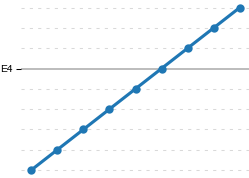

In [11]:
plt.figure(figsize=cm2inch(5, 4))
M.plot(M.sequence('G3', 8), 'o-')
M.grid()
despine()

All this also works for the tintinnabuli space: that is also a pitch space, but one that only consists of triad notes:

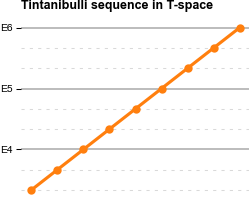

In [12]:
plt.figure(figsize=cm2inch(5, 4))
T.plot(T.sequence('G3', 8), 'o-', c='C1')
T.grid()
despine()
title('Tintinnabuli sequence in T-space')

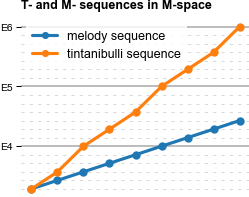

In [13]:
plt.figure(figsize=cm2inch(5, 4))
M.plot(M.sequence('G3', 8), 'o-', c='C0', label='melody sequence')
M.plot(T.sequence('G3', 8), 'o-', c='C1', label='tintinnabuli sequence')
M.grid()
despine()
plt.legend()
title('T- and M- sequences in M-space')

### Modes

The four (melodic) modes by Hillier: four ways to move away from, or towards, the pitch center.

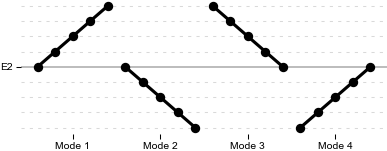

In [14]:
plt.figure(figsize=cm2inch(8, 3))
M = MelodicSpace(MinorScale('E2'))
M.plot(M.mode1(4), 'k.-', ms=7)
M.plot(M.mode2(4), 'k.-', ms=7, xs=range(5, 10))
M.plot(M.mode3(4), 'k.-', ms=7, xs=range(10, 15))
M.plot(M.mode4(4), 'k.-', ms=7, xs=range(15, 20))
M.grid()
despine()
plt.xticks([2, 7, 12, 17], [f'Mode {i}' for i in range(1, 5)]);

## 2. Constructing melodic voices

### Basic operations

Modes and several operations can be combined to create all sorts of melodies. The central patterns of the alto and bass in _Summa_ can be created as follows:

In [15]:
M = MelodicSpace(MinorScale('E4'))
alto = glue(M.mode2(5), M.mode4(5), M.mode1(2), M.mode3(2))
bass = M.transpose(M.mirror(alto), -6)

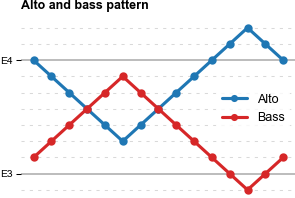

In [16]:
plt.figure(figsize=cm2inch(6, 4))
M.plot(alto, 'o-', label='Alto')
M.plot(bass, 'o-', c='C3', label='Bass')
despine()
M.grid()
plt.legend()
title('Alto and bass pattern')
# plt.savefig('../figures/alto-bass-pattern/alto-bass-pattern-raw.pdf')

### Tail rotation

The patterns of the alto and bass are repeated throughout the piece, but every time the pattern is rotated one step to the left, while the very first note (the tonic) remains unchanged. What rotates, in other words, is the _tail_ of the pattern: everything after the first note. Here we illustrate tail rotation for various distances:

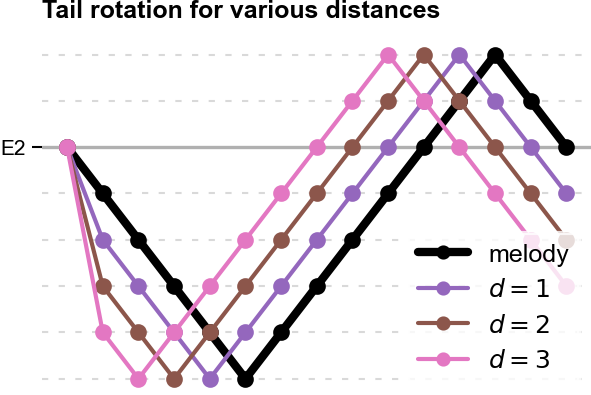

In [17]:
plt.figure(figsize=cm2inch(6, 4))

M = MelodicSpace(MinorScale('E2'))
alto = glue(M.mode2(5), M.mode4(5), M.mode1(2), M.mode3(2))

M.plot(alto, 'ko-', lw=2, label='melody')
M.plot(rotate_tail(alto, 1), 'o-', label='$d=1$', c='C4', lw=1)
M.plot(rotate_tail(alto, 2), 'o-', label='$d=2$', c='C5', lw=1)
M.plot(rotate_tail(alto, 3), 'o-', label='$d=3$', c='C6', lw=1)
despine()
plt.legend()
M.grid()
title('Tail rotation for various distances')
# plt.savefig('../figures/tail-rotation/tail-rotation-raw.pdf')

## 3. Tintinnabuli voices

In works of Pärt it is common to find that the relation between an M-voice and a T-voice is completely fixed: each pitch in the M-voice corresponds to a pitch in the T-voice. In _Summa_ we find more complex relations, that may involve other melody notes as well. We call these _tintinnabuli processes_. They generally define a sequence of tintinnabuli notes $(t_1, \dots, t_i, \dots, t_N)$ by some function $X$ as
\begin{align}
t_{i+1} = X\bigl((t_1, \dots, t_i), \; (m_1, \dots, m_N)\bigr).
\end{align}
We give some examples of tintinnabuli processes here.

### Constant process

First a constant process, which simply returns the tintinnabuli note in $p$-th position all the time.

In [18]:
m_kws = dict(c='k', lw=1, ms=4)
p1_kws = dict(c='C9', marker='s', ms=1.7, lw=1)
p2_kws = dict(c='C8', marker='v', ms=1.5, lw=1)

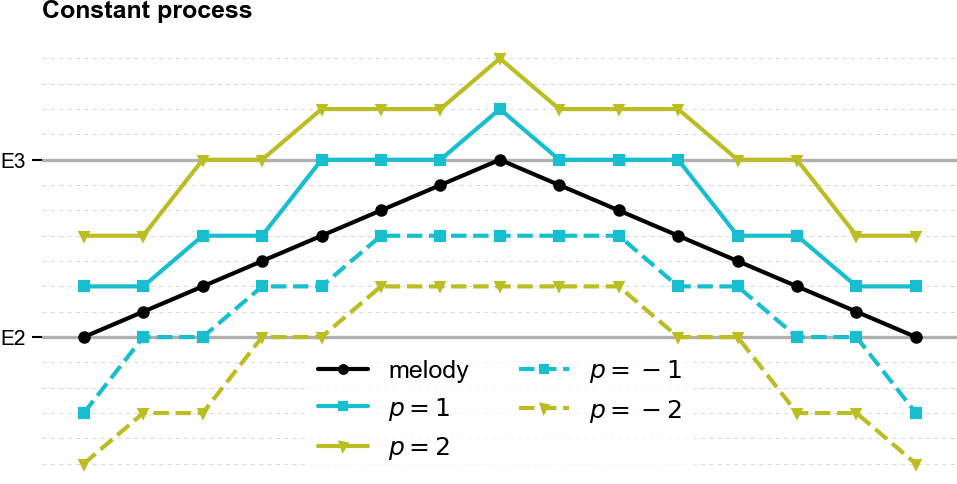

In [19]:
def show_constant_process(mel, M, T, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    M.plot(mel, '.-', label='melody', **m_kws)
    M.plot(ConstantProcess(T, position=1)(mel), label='$p=1$', **p1_kws)
    M.plot(ConstantProcess(T, position=2)(mel), label='$p=2$', **p2_kws)
    M.plot(ConstantProcess(T, position=-1)(mel), '--', label='$p=-1$', **p1_kws)
    M.plot(ConstantProcess(T, position=-2)(mel), '--', label='$p=-2$', **p2_kws)
    M.grid(minor_kws=dict(dashes=(4,4), lw=.25))
    despine(ax=ax)

plt.figure(figsize=cm2inch(10, 5))
melody = glue(M.mode1(7), M.mode3(7))
show_constant_process(melody, M, T)
plt.legend(ncol=2)
title('Constant process')

### Alternating process

Second Hillier's alternating 'position', where the position flips sign every time:

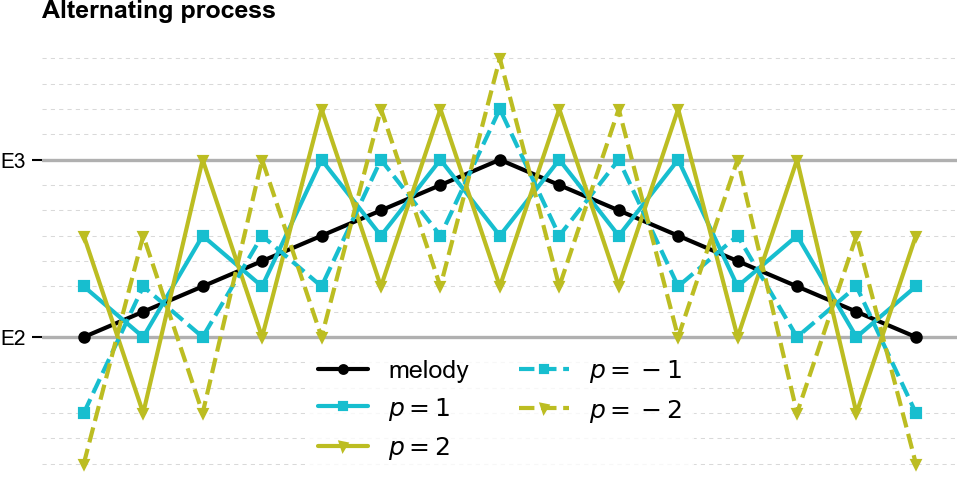

In [20]:
def show_alternating_process(mel, M, T, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    M.plot(mel, '.-', label='melody', **m_kws)
    M.plot(AlternatingProcess(T)(mel, p0=1), label='$p=1$', **p1_kws)
    M.plot(AlternatingProcess(T)(mel, p0=2), label='$p=2$', **p2_kws)
    M.plot(AlternatingProcess(T)(mel, p0=-1), '--', label='$p=-1$', **p1_kws)
    M.plot(AlternatingProcess(T)(mel, p0=-2), '--', label='$p=-2$', **p2_kws)
    M.grid(minor_kws=dict(dashes=(4,4), lw=.25))
    despine(ax=ax)
    
plt.figure(figsize=cm2inch(10, 5))
melody = glue(M.mode1(7), M.mode3(7))
show_alternating_process(melody, M, T)
title('Alternating process')
plt.legend(ncol=2)

### Step process

Finally the step process which we find in _Summa_. Here the process moves stepwise through T-space while remaining in at least a certain position $p$ with respect to the melody:

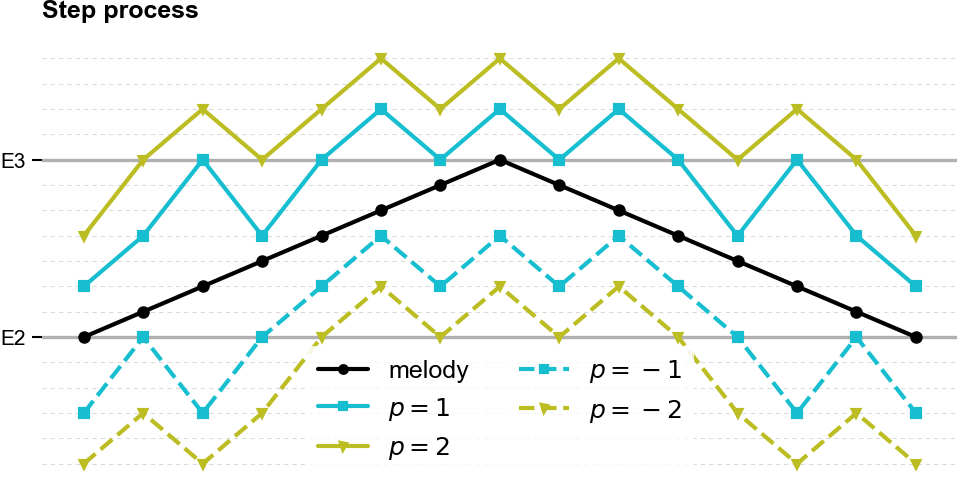

In [21]:
def show_step_process(mel, M, T, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    M.plot(mel, '.-', label='melody', **m_kws)
    M.plot(StepProcess(T, position=1)(mel), label='$p=1$', **p1_kws)
    M.plot(StepProcess(T, position=2)(mel), label='$p=2$', **p2_kws)
    M.plot(StepProcess(T, position=-1)(mel), '--', label='$p=-1$', **p1_kws)
    M.plot(StepProcess(T, position=-2)(mel), '--', label='$p=-2$', **p2_kws)
    M.grid(minor_kws=dict(dashes=(4,4), lw=.25))
    despine(ax=ax)

plt.figure(figsize=cm2inch(10, 5))
melody = glue(M.mode1(7), M.mode3(7))
show_step_process(melody, M, T)
title('Step process')
plt.legend(ncol=2)

### Figure: 3 processes

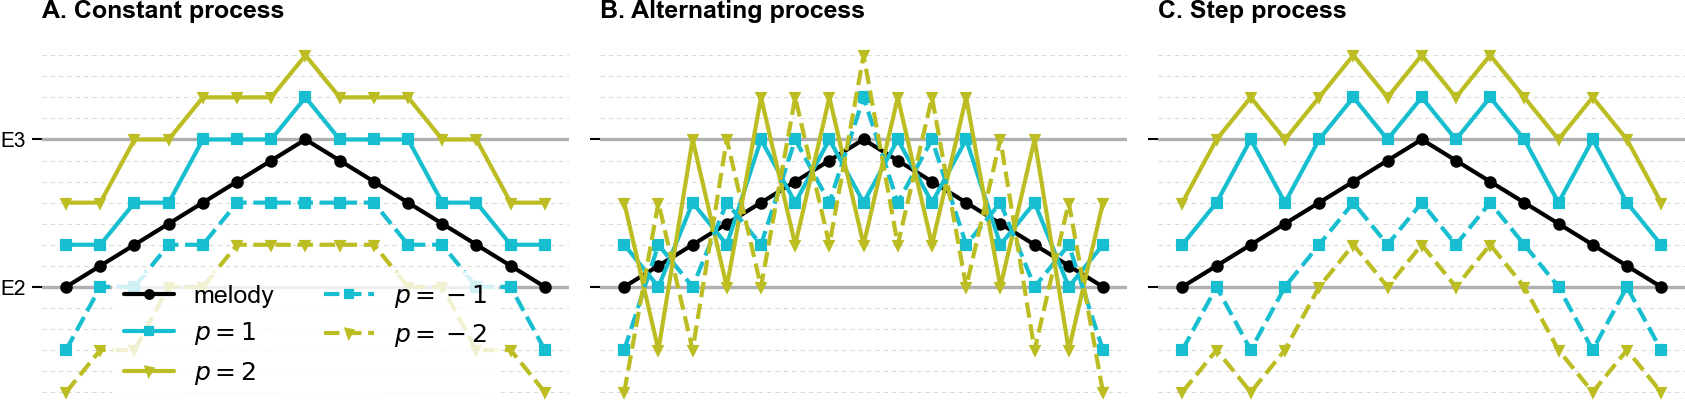

In [22]:
fig, axs = plt.subplots(1, 3, figsize=cm2inch(14.8, 4), tight_layout=True, sharey=True)

melody = glue(M.mode1(7), M.mode3(7))

show_constant_process(melody, M, T, ax=axs[0])
title('A. Constant process', ax=axs[0])
plt.legend(ncol=2)

show_alternating_process(melody, M, T, ax=axs[1])
title('B. Alternating process', ax=axs[1])

show_step_process(melody, M, T, ax=axs[2])
title('C. Step process', ax=axs[2])

for ax in axs:
    ax.set_xticks([])
    
plt.savefig('../figures/tintinnabuli-processes/tintinnabuli-processes-raw.pdf')

### Figure: (unornamented) melodic material in Summa

In [23]:
M = MelodicSpace(MinorScale('E4'))
T = TintinnabuliSpace(Chord(['E4', 'G4', 'B4']))
alto_pattern = glue(M.mode2(6), M.mode4(6), M.mode1(2), M.mode3(2))[:-1]
repetitions = [rotate_tail(alto_pattern, i) for i in range(16)]
alto = concatenate(*repetitions)
bass = M.transpose(M.mirror(alto), -7)
soprano = StepProcess(T, position=2)(alto)
tenor = StepProcess(T, position=1)(bass, p0=2)

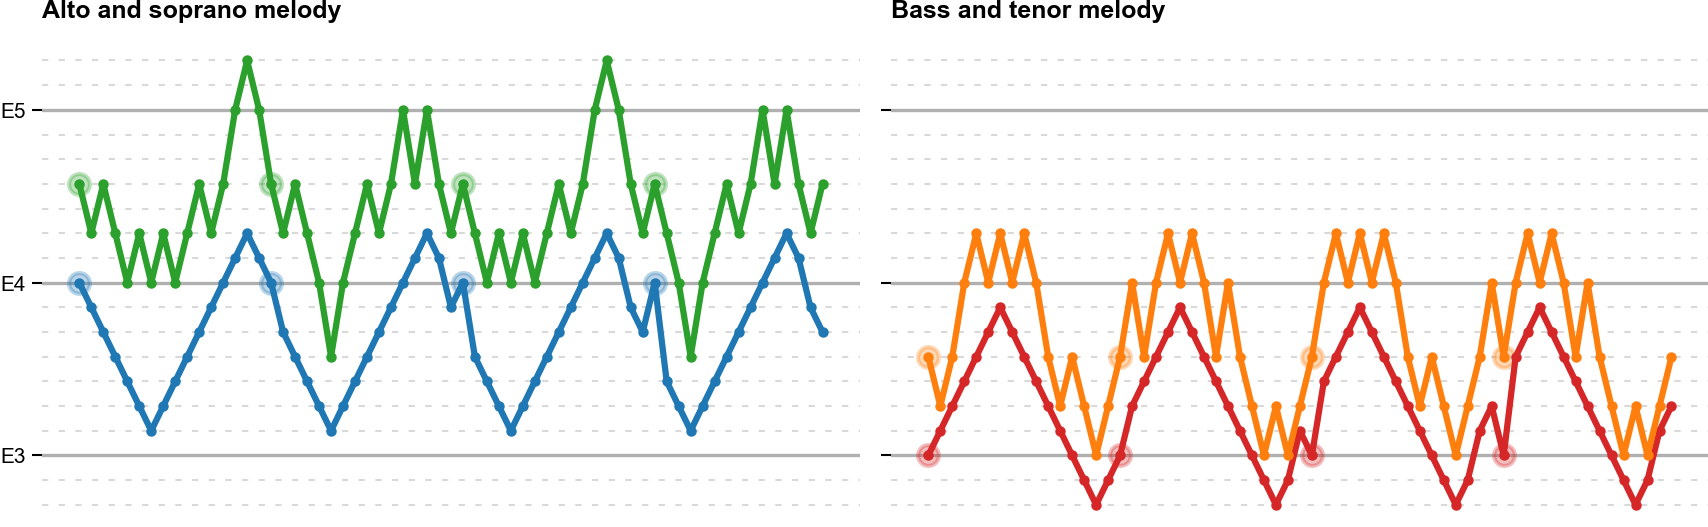

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, tight_layout=True, 
                               figsize=cm2inch(15, 5), sharey=True)
N = 4*16 - 1

plt.sca(ax0)
plt.plot(np.arange(0, N, 16), np.zeros(4), 'o', c='C0', ms=5, alpha=.3)
plt.plot(np.arange(0, N, 16), np.ones(4) * 4, 'o', c='C2', ms=5, alpha=.3)
M.plot(alto[:N], '.-', c='C0')
M.plot(soprano[:N], '.-', c='C2')
M.grid()
despine()
title('Alto and soprano melody')

plt.sca(ax1)
plt.plot(np.arange(0, N, 16), np.ones(4) - 4, 'o', c='C1', ms=5, alpha=.3)
plt.plot(np.arange(0, N, 16), np.ones(4) - 8, 'o', c='C3', ms=5, alpha=.3)
M.plot(bass[:N], '.-', c='C3')
M.plot(tenor[:N], '.-', c='C1')
M.grid()
despine()
title('Bass and tenor melody')

## 4. Ornaments

### Tenor and soprano 

In [25]:
class OrnamentProcess2(TintinnabuliProcess):
    def __init__(self, T, min_pitch, max_pitch):
        self.min_pitch = Pitch(min_pitch)
        self.max_pitch = Pitch(max_pitch)
#         self.max_target = Pitch(max_target)
#         self.min_target = Pitch(min_target)
        super().__init__(T)
        
    def step(self, i, melody, ts):
        # Very last step
        if i == len(melody) - 1:
            return False
                                
        in_range = self.min_pitch <= melody[i-1] #<= self.max_pitch
        target_in_range = melody[i+1] <= self.max_pitch
        if (melody[i-1] != melody[i+1]) and in_range and target_in_range:
            return melody[i-1]
        else:
            return False



../tintinnabulipy/spaces.py:423: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.plot(xs, self.step(melody), *args, **kwargs)


(0.0, 60.0)

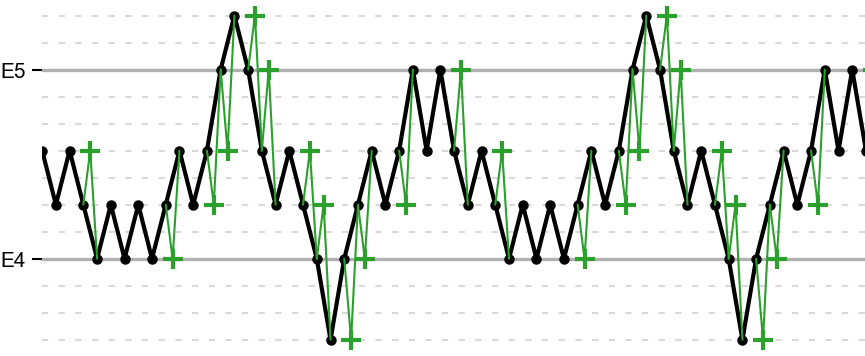

In [26]:
def show_ornamental_voice(M, voice, ornaments, c='C4', ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    voice = np.array(voice)
    ornaments = np.array(ornaments)    
    M.plot(voice, '.-k', lw=1)
    indices = np.where(ornaments != False)[0]
    for i in indices:
        if i == len(ornaments)-1: continue
        xs = [i, i+.5, i+1]
        ys = [voice[i], ornaments[i], voice[i+1]]
        M.plot(ys, xs=xs, C=c, lw=.5)
        M.plot([ornaments[i]], xs=[i+.5], marker='+', C=c, ms=5)
    despine()
    M.grid()


process = OrnamentProcess2(T, 'E2', 'E6')
soprano_ornaments = process(soprano, t0=False)
plt.figure(figsize=cm2inch(9, 4))
show_ornamental_voice(M, soprano, soprano_ornaments, c='C2')
plt.xlim(0, 60)

../tintinnabulipy/spaces.py:423: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.plot(xs, self.step(melody), *args, **kwargs)


(0.0, 60.0)

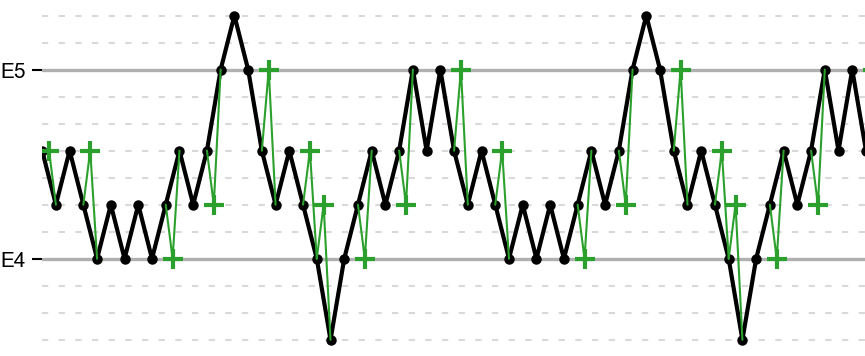

In [27]:
def show_ornamental_voice(M, voice, ornaments, c='C4', ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    voice = np.array(voice)
    ornaments = np.array(ornaments)    
    M.plot(voice, '.-k', lw=1)
    indices = np.where(ornaments != False)[0]
    for i in indices:
        if i == len(ornaments)-1: continue
        xs = [i, i+.5, i+1]
        ys = [voice[i], ornaments[i], voice[i+1]]
        M.plot(ys, xs=xs, C=c, lw=.5)
        M.plot([ornaments[i]], xs=[i+.5], marker='+', C=c, ms=5)
    despine()
    M.grid()


process = OrnamentProcess(T, 'E4', 'E5', max_target='E5')
soprano_ornaments = process(soprano, t0=soprano[0])
plt.figure(figsize=cm2inch(9, 4))
show_ornamental_voice(M, soprano, soprano_ornaments, c='C2')
plt.xlim(0, 60)

../tintinnabulipy/spaces.py:423: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.plot(xs, self.step(melody), *args, **kwargs)
../tintinnabulipy/spaces.py:423: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.plot(xs, self.step(melody), *args, **kwargs)


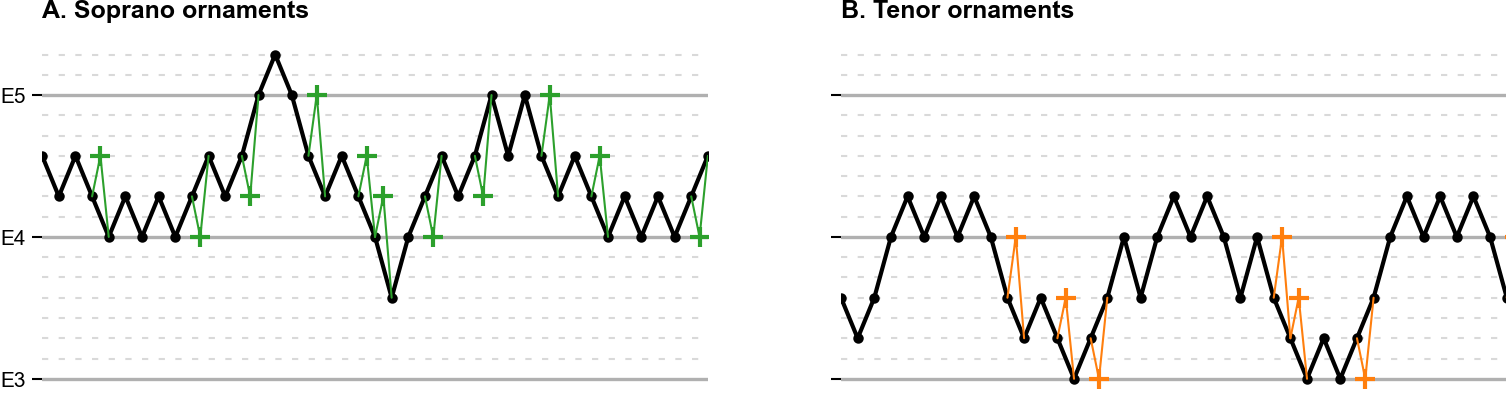

In [28]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=cm2inch(16, 4), sharey=True)

process = OrnamentProcess(T, 'E4', 'E5', max_target='E5')
soprano_ornaments = process(soprano, t0=False)
show_ornamental_voice(M, soprano, soprano_ornaments, c='C2', ax=ax0)
plt.xlim(0, 40)
title('A. Soprano ornaments')

process = OrnamentProcess(T, 'E3', 'E4', max_target='B3')
tenor_ornaments = process(tenor, t0=False)
show_ornamental_voice(M, tenor, tenor_ornaments, c='C1', ax=ax1)
plt.xlim(0, 40)
title('B. Tenor ornaments');

plt.savefig('../figures/repeat-previous-process/repeat-previous-process.pdf')

## Alto and bass

In [29]:
alto_pattern = [None, 'G3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None]
bass_pattern = [None, None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2']

../tintinnabulipy/spaces.py:423: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.plot(xs, self.step(melody), *args, **kwargs)
../tintinnabulipy/spaces.py:423: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.plot(xs, self.step(melody), *args, **kwargs)


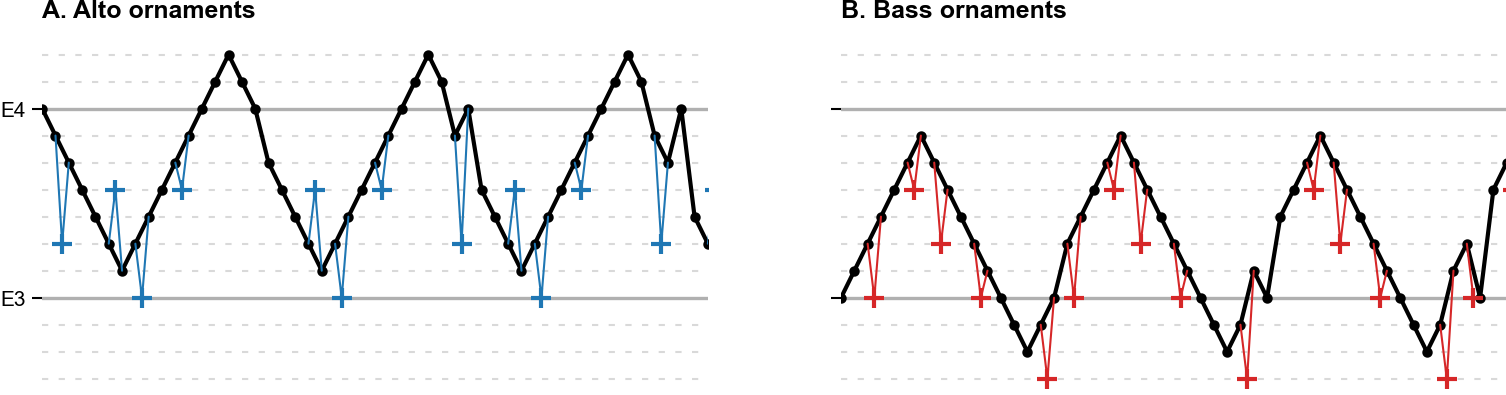

In [36]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=cm2inch(16, 4), sharey=True)

process = TailRotatedPatternProcess(T, alto_pattern)
alto_ornaments = process(alto, t0=False)
show_ornamental_voice(M, alto, alto_ornaments, c='C0', ax=ax0)
plt.xlim(0, 50)
title('A. Alto ornaments')

process = TailRotatedPatternProcess(T, bass_pattern)
bass_ornaments = process(bass, t0=False)
show_ornamental_voice(M, bass, bass_ornaments, c='C3', ax=ax1)
plt.xlim(0, 50)
title('B. Bass ornaments');

plt.savefig('../figures/tail-rotated-pattern-process/tail-rotated-pattern-process.pdf')